Now that we have collected a lot of data, let's try to combine it all and see if it's useful in prediction! Let's assume that the task is nowcasting, that we are given data up to this year and have to predict the refugee traffic of the current year.

First, let's load in the data sources

In [67]:
import pandas as pd
import numpy as np

path = '../../data/clean/'

# data from geraldine
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')

# yearly sources from the internet
idp = pd.read_csv(path + 'idp.csv', engine='pyarrow')
fsi = pd.read_csv(path + 'fragility_indices.csv', engine='pyarrow')
migration = pd.read_csv(path + 'migration_stocks.csv')

# monthly sources from hannes + gdelt team
conflict = pd.read_csv(path + 'mueller_conflict_forecasts.csv')
lda = pd.read_csv(path + 'lda.csv')
gdelt = pd.read_csv(path + 'gdelt.csv', engine='pyarrow')

trends_path = '../../notebooks/trends/data/'
# monthly trends data
# semantic_trends = pd.read_csv(trends_path + 'semantic_topic_trends.csv')
# main_cities_trends = pd.read_csv(trends_path + 'city_topic_trends_1.csv')
# countries_trends = pd.read_csv(trends_path + 'country_topic_trends_1.csv')
# border_cities_trends = pd.read_csv(trends_path + 'bordering_cities_trends.csv')

That's a lot of sources! First thing I think of is we need to convert conflict, lda, and gdelt to a yearly format.

There are multiple ways to do this. A simple approach is to summarize and do boxplots of the months, aggregating to yearly data. 

Here we have the function agg_year, which produces a boxplot, but also includes the log difference of the data, to represent the average log change for a given year.

In [68]:
def avg_log_diff(series):
    val = np.log1p(series).diff().mean()
    if np.isnan(val):
        return 0
    else:
        return val

# Define the agg_year function
def agg_year(series):
    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum, log_diff]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','mean','75th','max', 'log_diff'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

This is another way to aggregate years where we convert a single year into 12 columns: 4 quarters and 4 summary statistics (min, mean, max, and pct change of the mean).

In [69]:
# apply this to conflict data
conflict = conflict.groupby(['isocode', 'year'])[['ons_armedconf12_pred_jut_x', 'ons_armedconf12_pred_top_x', 'ons_armedconf12_pred_aug_x', 
                                                  'ons_armedconf12_pred_jut_y', 'ons_armedconf12_pred_top_y', 'ons_armedconf12_pred_aug_y', 
                                                  'lnbest_pc_12_pred_jut', 'lnbest_pc_12_pred_top', 'lnbest_pc_12_pred_aug']].agg(agg_year)

conflict = split_df(conflict)

In [70]:
# now the lda data
lda = lda.groupby(['isocode','year'])[['ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3',
       'ste_theta4', 'ste_theta5', 'ste_theta6', 'ste_theta7', 'ste_theta8',
       'ste_theta9', 'ste_theta10', 'ste_theta11', 'ste_theta12',
       'ste_theta13', 'ste_theta14', 'ste_theta0_stock', 'ste_theta1_stock',
       'ste_theta2_stock', 'ste_theta3_stock', 'ste_theta4_stock',
       'ste_theta5_stock', 'ste_theta6_stock', 'ste_theta7_stock',
       'ste_theta8_stock', 'ste_theta9_stock', 'ste_theta10_stock',
       'ste_theta11_stock', 'ste_theta12_stock', 'ste_theta13_stock',
       'ste_theta14_stock', 'sentiment_stock']].agg(agg_year)
lda = split_df(lda)

In [71]:
gdelt = gdelt.groupby(['isocode','year'])[['count_events_1',
       'count_events_2', 'count_events_3', 'count_events_4', 'count_events_5',
       'count_events_6', 'count_events_7', 'count_events_8', 'count_events_9',
       'count_events_10', 'count_events_11', 'count_events_12',
       'count_events_13', 'count_events_14', 'count_events_15',
       'count_events_16', 'count_events_17', 'count_events_18',
       'count_events_19', 'count_events_20']].agg(agg_year)
gdelt = split_df(gdelt)

In [72]:
an_index = unhcr[['iso_o','iso_d','year','Id']].copy()
columns_to_drop = ['Country_o','Country_d']
unhcr.drop(columns_to_drop, axis=1, inplace=True)

This is a mapper to get the continent for a given country.

In [73]:
import pycountry_convert as pc

def country_to_continent(iso3):
    if iso3 == 'UVK':
        return 'EU'
    elif iso3 =='TLS':
        return 'OC'
    elif iso3 =='WBG':
        return 'AS'

    country_alpha2 = pc.country_alpha3_to_country_alpha2(iso3)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    return country_continent_code

def mapper(series, converter):
    unique_keys = series.drop_duplicates()
    unique_vals = unique_keys.apply(converter)
    mapper_dict = dict(zip(unique_keys, unique_vals))
    series = series.map(mapper_dict)
    series.name = series.name + '_continent'
    return series

In [74]:
continents = unhcr[['iso_o','iso_d']].apply(lambda x: mapper(x, country_to_continent)).rename({'iso_o':'iso_o_continent','iso_d':'iso_d_continent'}, axis=1)
unhcr = pd.concat([continents, unhcr], axis=1)

Let's merge the data with the other yearly sources

In [75]:
unhcr_extra = unhcr.merge(idp.drop('', axis=1), on=['iso_o', 'year'], how='left') \
    .merge(fsi, left_on=['iso_o', 'year'], right_on=['iso', 'year'], how='left') \
    .drop('iso', axis=1) \
    .merge(fsi, left_on=['iso_d', 'year'], right_on=['iso', 'year'], how='left', suffixes=('_o','_d')) \
    .drop('iso', axis=1) \
    .merge(migration, on=['year','iso_o','iso_d'])

And now let's merge with the other monthly sources that have been aggregated

In [76]:
unhcr_extra = unhcr_extra.merge(conflict, how='left',left_on=['iso_o','year'], right_on=['isocode','year']) \
    .merge(lda, how='left', left_on=['iso_o','year'], right_on=['isocode','year']) \
    .merge(gdelt,  how='left', left_on=['iso_o','year'], right_on=['isocode','year'])

The additional dataframes take up a lot of space and slow down computation time, so let's delete them.

In [77]:
import gc

del gdelt; del unhcr; del lda; del conflict; del fsi; del idp; del migration

gc.collect()

0

And now, let's create a lagged features, in this case let's do 2 years of lagged features.

In [80]:
from multiprocesspandas import applyparallel

def multi_shift(df, shift_range, columns):
    shifted_data = [df[columns].shift(shift_value) for shift_value in range(shift_range.start, shift_range.stop)]
    shifted_df = pd.concat(shifted_data, axis=1, keys=[f'Shift_{shift_value}' for shift_value in range(shift_range.start, shift_range.stop)])
    shifted_df.columns = shifted_df.columns.map(lambda col: '_'.join(col).strip())
    return shifted_df

shift_cols = ['newarrival','dead_o','fsi_overall_o','dead_d','ons_armedconf12_pred_top_x_mean', 'ons_armedconf12_pred_top_x_75th', 'ons_armedconf12_pred_top_x_log_diff']
# shift_cols = ['newarrival','dead_o','fsi_overall_o']

shifted_features = unhcr_extra[shift_cols].copy()
shifted_features = pd.concat([shifted_features, an_index], axis=1).set_index(an_index.columns.tolist()).groupby('Id', group_keys=False).apply(lambda x: multi_shift(x, range(1,3), shift_cols))

In [81]:
unhcr_extra = pd.concat([unhcr_extra, shifted_features.reset_index(drop=True)], axis=1)

In [82]:
del shifted_features; del continents; del an_index
gc.collect()

0

In [124]:
def create_train_test(unhcr_extra, split):
    unhcr_extra = unhcr_extra.copy()
    newarrival_not_na = (~unhcr_extra.newarrival.isna()) & (~unhcr_extra.Shift_2_newarrival.isna())
    train_idx = (unhcr_extra.year > 2007) & (unhcr_extra.year <= split) & newarrival_not_na
    test_idx = (unhcr_extra.year > split) & newarrival_not_na
    X_train = unhcr_extra.loc[train_idx, unhcr_extra.columns != 'newarrival']
    y_train = unhcr_extra.loc[train_idx , 'newarrival']
    X_test = unhcr_extra.loc[test_idx, unhcr_extra.columns != 'newarrival']
    y_test = unhcr_extra.loc[test_idx, 'newarrival']
    y_pred_naive = unhcr_extra.groupby('Id').newarrival.shift(1).loc[test_idx]
    return X_train, y_train, X_test, y_test, y_pred_naive

X_train, y_train, X_test, y_test, y_naive = create_train_test(unhcr_extra, 2017)

In [109]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline

be = BinaryEncoder()
cont_scaler = RobustScaler()

binary_cols = ['iso_o','iso_d','iso_o_continent','iso_d_continent', 'Id']
ignore_cols = ['conflict_stock_idp_pop_0',
       'conflict_stock_idp_pop_1', 'conflict_stock_idp_pop_2',
       'conflict_stock_idp_pop_3', 'conflict_stock_idp_pop_4',
       'conflict_idp_pop_0', 'conflict_idp_pop_1', 'conflict_idp_pop_2',
       'conflict_idp_pop_3', 'conflict_idp_pop_4']
numerical_cols = list(set(unhcr_extra.columns) - set(binary_cols + ignore_cols))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [('cat', be, binary_cols)],
    # ('numerical', cont_pipe, numerical_cols)],
     remainder='passthrough')

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(n_jobs=-1))])

In [110]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['iso_o', 'iso_d',
                                                   'iso_o_continent',
                                                   'iso_d_continent',
                                                   'Id'])])),
                ('rf', RandomForestRegressor(n_jobs=-1))])

In [112]:
y_pred = rf_pipe.predict(X_test)

In [135]:
unhcr_extra[~unhcr_extra.newarrival.isna()]

,iso_o_continent,iso_d_continent,iso_o,iso_d,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,...,Shift_1_ons_armedconf12_pred_top_x_mean,Shift_1_ons_armedconf12_pred_top_x_75th,Shift_1_ons_armedconf12_pred_top_x_log_diff,Shift_2_newarrival,Shift_2_dead_o,Shift_2_fsi_overall_o,Shift_2_dead_d,Shift_2_ons_armedconf12_pred_top_x_mean,Shift_2_ons_armedconf12_pred_top_x_75th,Shift_2_ons_armedconf12_pred_top_x_log_diff
0,AS,EU,AFG,ALB,2000,19.500,-3042.840501,1342.77,0.036,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS,EU,AFG,ALB,2001,19.700,-2103.557431,1392.77,0.036,0,...,0.552818,0.609259,-0.007045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS,EU,AFG,ALB,2002,18.707,649.220570,1442.77,0.036,0,...,0.554766,0.594786,0.003992,4.0,1.0,NaN,0.0,0.552818,0.609259,-0.007045
3,AS,EU,AFG,ALB,2003,19.477,6.530000,1506.22,0.037,0,...,0.547578,0.574180,-0.002869,0.0,1.0,NaN,0.0,0.554766,0.594786,0.003992
4,AS,EU,AFG,ALB,2004,20.237,13.266000,1459.35,0.036,0,...,0.499888,0.508043,-0.000466,0.0,1.0,NaN,0.0,0.547578,0.574180,-0.002869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955492,AF,AF,ZWE,ZMB,2017,14.437,3.430000,2311.53,0.027,0,...,0.141859,0.144807,0.006815,2.0,0.0,100.000000,0.0,0.090683,0.093818,-0.002671
955493,AF,AF,ZWE,ZMB,2018,14.642,42.074000,2387.04,0.028,0,...,0.156093,0.193146,0.006832,2.0,0.0,100.500000,0.0,0.141859,0.144807,0.006815
955494,AF,AF,ZWE,ZMB,2019,14.905,521.150000,2200.74,0.025,0,...,0.238051,0.250770,-0.004368,0.0,0.0,101.600000,0.0,0.156093,0.193146,0.006832
955495,AF,AF,ZWE,ZMB,2020,15.189,348.586000,2048.27,0.025,0,...,0.161706,0.187285,-0.005174,2.0,0.0,102.293753,0.0,0.238051,0.250770,-0.004368


In [136]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)/mean_squared_error(y_test, y_naive, squared=False)

0.8613538564249137

In [138]:
mean_squared_error(y_test, y_naive, squared=False)

4584.115029478711

In [159]:
results_df= pd.concat([y_test.reset_index(drop=True),y_naive.rename('naive').reset_index(drop=True),pd.Series(y_pred, name='RF_model')], axis=1)

In [161]:
# Compute RMSE for each row
results_df['naive_error'] = np.sqrt((results_df['newarrival'] - results_df['naive']) ** 2)
results_df['RF_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_model']) ** 2)
# results_df['RF_outflow_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
results_df['actual_range'] = pd.cut(results_df['newarrival'], ranges, labels=labels, include_lowest=True)

In [162]:
# Compute mean RMSE for each group
grouped_errors = results_df[['naive_error', 'RF_error','actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error
actual_range,,
0-10,2.033208,6.990320
10-100,36.209227,103.886694
100-1k,280.194662,1021.608148
1k-10k,2386.465937,5089.542603
10k-100k,31011.180556,33434.811389
100k+,240486.625000,191071.653750


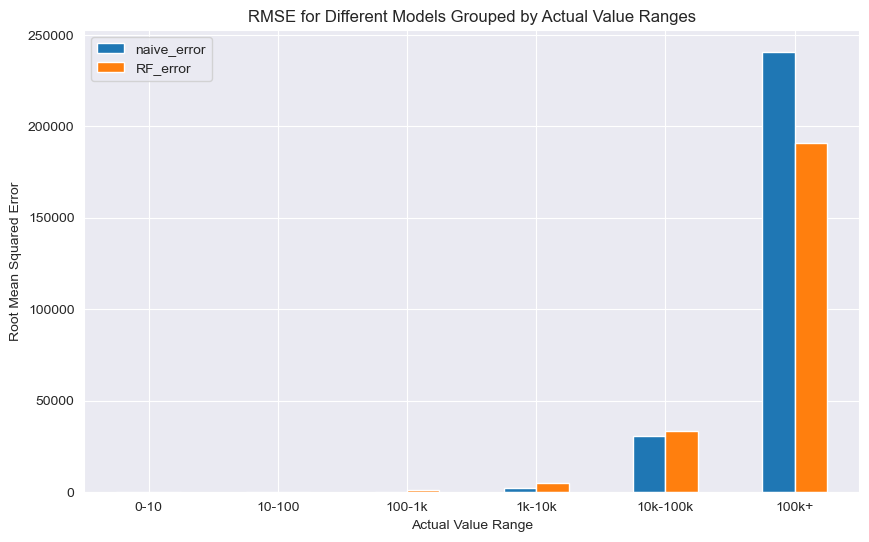

In [175]:
# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

In [191]:
results_df['newarrival - RF'] = results_df['newarrival'] - results_df['RF_model']
results_df['newarrival - naive'] = results_df['newarrival'] - results_df['naive']
results_df.loc[results_df['RF_model'] <= 1, 'RF_model'] = np.round(results_df.loc[results_df['RF_model'] <= 1, 'RF_model'])

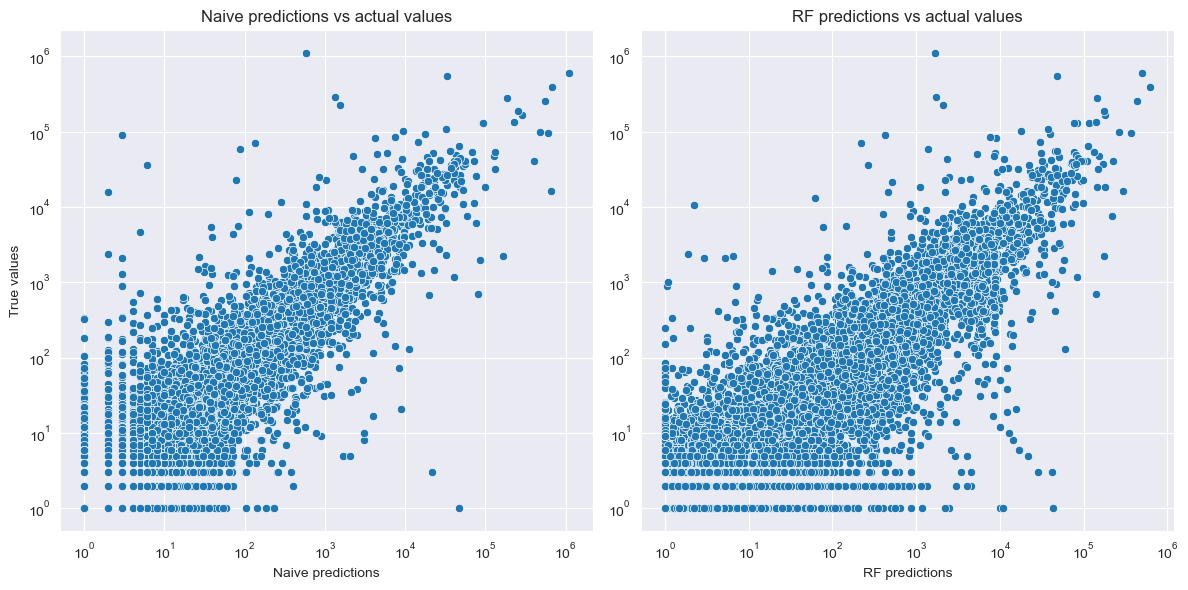

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=results_df, x='naive', y='newarrival', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=results_df, x='RF_model', y='newarrival', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions vs actual values')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
